In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
pd.options.display.precision = 15
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from numba import jit
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

seed = 42
seed_everything(seed)

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME']='mjkimcs'
os.environ['KAGGLE_KEY']='7d10c5f08a131943194c8cd3e4aa633f'

In [ ]:
!kaggle competitions download -c ieee-fraud-detection
!unzip '*.zip'

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 105MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 158MB/s]
 79% 41.0M/52.2M [00:00<00:00, 52.7MB/s]
100% 52.2M/52.2M [00:00<00:00, 95.7MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 108MB/s]
 72% 42.0M/58.3M [00:00<00:00, 107MB/s]
100% 58.3M/58.3M [00:00<00:00, 147MB/s]
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

5 archives were successfully processed.


In [ ]:
!ls

sample_data		   test_identity.csv.zip     train_identity.csv.zip
sample_submission.csv	   test_transaction.csv      train_transaction.csv
sample_submission.csv.zip  test_transaction.csv.zip  train_transaction.csv.zip
test_identity.csv	   train_identity.csv


In [ ]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
sub = pd.read_csv('sample_submission.csv')

In [ ]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train_identity.shape

(144233, 41)

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
train_transaction.shape

(590540, 394)

In [ ]:
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [ ]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.949999999999999,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000000000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0

In [ ]:
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [ ]:
del train_transaction, train_identity, test_transaction, test_identity

In [ ]:
train.isna().any()

TransactionID     False
isFraud           False
TransactionDT     False
TransactionAmt    False
ProductCD         False
card1             False
card2              True
card3              True
card4              True
card5              True
card6              True
addr1              True
addr2              True
dist1              True
dist2              True
P_emaildomain      True
R_emaildomain      True
C1                False
C2                False
C3                False
C4                False
C5                False
C6                False
C7                False
C8                False
C9                False
C10               False
C11               False
C12               False
C13               False
C14               False
D1                 True
D2                 True
D3                 True
D4                 True
D5                 True
D6                 True
D7                 True
D8                 True
D9                 True
D10                True
D11             

In [ ]:
test.isna().any()

TransactionID     False
TransactionDT     False
TransactionAmt    False
ProductCD         False
card1             False
card2              True
card3              True
card4              True
card5              True
card6              True
addr1              True
addr2              True
dist1              True
dist2              True
P_emaildomain      True
R_emaildomain      True
C1                 True
C2                 True
C3                 True
C4                 True
C5                 True
C6                 True
C7                 True
C8                 True
C9                 True
C10                True
C11                True
C12                True
C13                True
C14                True
D1                 True
D2                 True
D3                 True
D4                 True
D5                 True
D6                 True
D7                 True
D8                 True
D9                 True
D10                True
D11                True
D12             

In [ ]:
test[[f'C{i}' for i in range(1,15)]] = test[[f'C{i}' for i in range(1,15)]].fillna(0)

In [ ]:
end_mem = train.memory_usage().sum() / 1024 ** 2 + test.memory_usage().sum() / 1024 ** 2
print(f'Mem. usage {end_mem:5.2f} Mb')

Mem. usage 3637.61 Mb


In [ ]:
def reduce_mem_usage(memory_df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = memory_df.memory_usage().sum() / 1024 ** 2
    for col in memory_df.columns:
        col_type = memory_df[col].dtypes
        if col_type in numerics:
            c_min = memory_df[col].min()
            c_max = memory_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    memory_df[col] = memory_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    memory_df[col] = memory_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    memory_df[col] = memory_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    memory_df[col] = memory_df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    memory_df[col] = memory_df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    memory_df[col] = memory_df[col].astype(np.float32)
                else:
                    memory_df[col] = memory_df[col].astype(np.float64)
    end_mem = memory_df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
    return memory_df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


###EDA

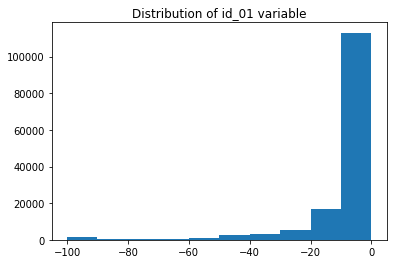

In [ ]:
plt.hist(train['id_01']);
plt.title('Distribution of id_01 variable');

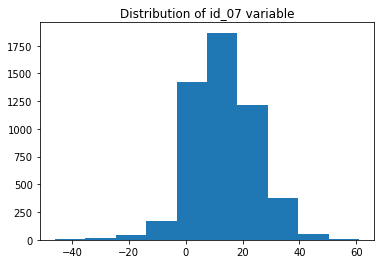

In [ ]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

In [ ]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: id_03, dtype: float64

In [ ]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN         0.761272733430420
100.0000    0.225491922647069
95.0625     0.002111626646798
95.1875     0.001359772411691
97.1250     0.000956751447827
Name: id_11, dtype: float64

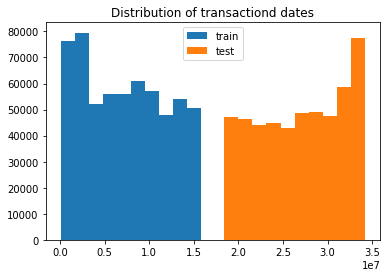

In [ ]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

* TransactionDT 항목은 실제타임이 아닌 델타타임  
* 시작일: 2017-11-30  

In [ ]:
start_date = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [ ]:
print (start_date)

2017-11-30 00:00:00


### Filling missing values in card columns

In [ ]:
for col in train.columns:
    if 'card' in col:
        print(f"{col} has {train[col].isnull().sum()} missing values.")

card1 has 0 missing values.
card2 has 8933 missing values.
card3 has 1565 missing values.
card4 has 1577 missing values.
card5 has 4259 missing values.
card6 has 1571 missing values.


In [ ]:
group_with_mode = train.groupby(['card1']).agg({'card2': ['nunique', pd.Series.mode]})
group_with_mode[60:70]

card2     
      nunique mode
card1             
1068        1  555
1070        1  369
1072        1  555
1073        1  310
1074        1  555
1075        0   []
1076        1  555
1078        1  512
1079        1  555
1080        1  555

In [ ]:
card1_nunique = train['card1'].nunique()
non_one = group_with_mode[group_with_mode['card2']['nunique'] > 1].shape[0]
print(f'Number of unique values of card1: {card1_nunique}')
print(f'Number of unique values of card1 which have more than one unique value: {non_one}')

Number of unique values of card1: 13553
Number of unique values of card1 which have more than one unique value: 248


In [ ]:
for card in ['card2','card3','card4','card5','card6']:
    group_with_mode = train.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(train['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(train[card])
    train[card] = merged['mode']
    
    group_with_mode = test.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(test['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(test[card])
    test[card] = merged['mode']

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0

## uid


In [ ]:
for df in [train,test]:
    df['DaysFromStart'] = np.floor(df['TransactionDT']/(60*60*24)) - 1
    df['D1-DaysFromStart'] = df['D1'] - df['DaysFromStart']

In [ ]:
for df in [train,test]:
    df['uid'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card4'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card5'].astype(str) + '_' + df['card6'].astype(str)
    df['uid'] = df['uid'] + '_' + df['addr1'].astype(str) + '_' + df['D1-DaysFromStart'].astype(str)

In [ ]:
len(set(train['uid']).intersection(set(test['uid']))), train.uid.nunique(), test.uid.nunique()

(26891, 231339, 205162)

In [ ]:
train['uid'].value_counts(dropna=False, normalize=True).head(20)

S_15775_481.0_150.0_mastercard_102.0_credit_330.0_-128.0    0.002394418667660
W_9500_321.0_150.0_visa_226.0_debit_126.0_86.0              0.000755240965896
W_8900_385.0_150.0_visa_226.0_debit_231.0_61.0              0.000392860771497
W_8528_215.0_150.0_visa_226.0_debit_387.0_160.0             0.000364073559793
C_12616_490.0_150.0_visa_nan_credit_nan_492.0               0.000357300098215
W_12741_106.0_150.0_visa_226.0_debit_143.0_203.0            0.000331899617299
W_7207_111.0_150.0_visa_226.0_debit_204.0_466.0             0.000323432790327
C_15885_545.0_185.0_visa_138.0_debit_nan_-21.0              0.000294645578623
W_13597_198.0_150.0_visa_226.0_debit_191.0_49.0             0.000250618078369
W_4121_361.0_150.0_visa_226.0_credit_476.0_9.0              0.000240457886003
C_15885_545.0_185.0_visa_138.0_debit_nan_-26.0              0.000231991059031
C_15885_545.0_185.0_visa_138.0_debit_nan_-19.0              0.000226910962848
C_15885_545.0_185.0_visa_138.0_debit_nan_-28.0              0.00

## DeviceInfo

In [ ]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True).head(20)

NaN                            0.799055102109933
Windows                        0.080810783350831
iOS Device                     0.033498154231720
MacOS                          0.021290683103600
Trident/7.0                    0.012598638534223
rv:11.0                        0.003219087614726
rv:57.0                        0.001629017509398
SM-J700M Build/MMB29K          0.000929657601517
SM-G610M Build/MMB29K          0.000780641446811
SM-G531H Build/LMY48B          0.000694279811698
rv:59.0                        0.000612998272767
SM-G935F Build/NRD90M          0.000565584041725
SM-G955U Build/NRD90M          0.000555423849358
SM-G532M Build/MMB29T          0.000535103464626
ALE-L23 Build/HuaweiALE-L23    0.000528330003048
SM-G950U Build/NRD90M          0.000491075964372
SM-G930V Build/NRD90M          0.000463982118061
rv:58.0                        0.000455515291090
rv:52.0                        0.000433501540963
SAMSUNG                        0.000397940867680
Name: DeviceInfo, dt

In [ ]:
train['DeviceInfo'].nunique()

1786

In [ ]:
for df in [train, test]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

In [ ]:
df['DeviceInfo_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice          0.772924721378513
windows                0.088787841110262
iosdevice              0.036945594060285
macos                  0.022003548513788
trident                0.009650852294594
rv                     0.005549733466748
smgu                   0.001569003593906
smgmbuildmmbt          0.001310463379061
motog                  0.001036134448806
smgf                   0.001018372143969
smjm                   0.000972979587165
smgfbuildrnw           0.000943375745770
smgm                   0.000937454977491
motogplus              0.000799303717650
samsungsmgubuildrnw    0.000785488591666
smgubuildrnw           0.000742069624288
smgmbuildmmbk          0.000724307319451
motogplay              0.000722333730025
motoebuildnma          0.000712465782893
smaf                   0.000645363742399
Name: DeviceInfo_device, dtype: float64

In [ ]:
df['DeviceInfo_version'].value_counts(dropna=False, normalize=True).head(20)

         0.923432624617370
70       0.009688350493693
3        0.002105819917859
53229    0.001722943569158
5        0.001636105634400
110      0.001482165659149
95016    0.001456508996607
610      0.001328225683898
4        0.001322304915619
33       0.001306516200209
950      0.001241387749141
6        0.001170338529794
0303     0.001091394952742
630      0.000935481388065
2        0.000894036010113
61029    0.000751937571419
70029    0.000696677067483
03       0.000696677067483
700      0.000672993994367
620      0.000661152457810
Name: DeviceInfo_version, dtype: float64

In [ ]:
df['id_30'].value_counts(dropna=False, normalize=True).head(20)

NaN                 0.860548144727260
Windows 10          0.041474981793638
Windows 7           0.020462175171850
iOS 12.1.0          0.012530319267561
iOS 11.4.1          0.006982559390240
Mac OS X 10_13_6    0.006422059993171
Android 8.0.0       0.004845162041560
iOS 12.0.1          0.003337339719869
iOS 11.4.0          0.003167611029207
Mac OS X 10_11_6    0.002869599025836
Windows 8.1         0.002751183660258
Linux               0.002668292904354
Mac OS X 10_12_6    0.002615005989844
iOS 12.0.0          0.002476854730003
iOS 12.1.2          0.002384096026967
Mac OS X 10_14_1    0.002097925560154
Mac OS X 10_10_5    0.001823596629899
Android             0.001517690268823
Android 7.0         0.001385459777261
iOS 11.3.0          0.001274938769388
Name: id_30, dtype: float64

In [ ]:
train['id_30'].nunique()

75

In [ ]:
df['id_31'].value_counts(dropna=False, normalize=True).head(20)

NaN                        0.730358344632133
chrome 70.0                0.031684004649777
mobile safari 12.0         0.025850074305642
mobile safari 11.0         0.020193767009874
chrome 71.0                0.018727390066135
chrome 69.0                0.016366977112283
chrome 70.0 for android    0.015046645786091
chrome 68.0                0.012727678210191
chrome 67.0                0.012082314467792
chrome 69.0 for android    0.011884955525162
ie 11.0 for desktop        0.010209378102236
chrome 71.0 for android    0.009925181224849
edge 17.0                  0.009613354095494
chrome 67.0 for android    0.007175971154017
safari 12.0                0.007006242463355
chrome 68.0 for android    0.006947034780566
safari 11.0                0.005717488567983
firefox 63.0               0.003747846320539
samsung browser 7.4        0.002701843924601
firefox 61.0               0.002607111632139
Name: id_31, dtype: float64

In [ ]:
for df in [train, test]:
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [ ]:
df['id_30_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice    0.860548144727260
windows          0.064873858031818
ios              0.036945594060285
macosx           0.023550842624006
android          0.010815270056109
linux            0.002668292904354
mac              0.000238804320582
windowsvista     0.000197358942630
windowsxp        0.000132230491562
func             0.000021709483689
other            0.000007894357705
Name: id_30_device, dtype: float64

## D-columns

In [ ]:
train.D1.value_counts()

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
7.0        3455
6.0        3164
5.0        3076
14.0       2979
8.0        2637
28.0       2634
9.0        2387
13.0       2369
42.0       2294
15.0       2222
11.0       2119
10.0       2115
12.0       2071
29.0       2039
21.0       2023
35.0       1964
16.0       1853
30.0       1812
27.0       1791
22.0       1715
20.0       1709
18.0       1707
17.0       1656
43.0       1623
26.0       1607
32.0       1584
19.0       1568
31.0       1549
23.0       1535
56.0       1499
25.0       1440
24.0       1434
36.0       1373
34.0       1368
33.0       1343
63.0       1337
41.0       1295
37.0       1221
55.0       1220
62.0       1206
49.0       1201
57.0       1200
91.0       1192
40.0       1162
70.0       1157
39.0       1130
38.0       1118
61.0       1105
48.0       1095
59.0       1094
60.0       1083
58.0       1079
84.0       1071
44.0       1068
50.0       1007
45.0       1002
54.0        994
64.0    

In [ ]:
train.D2.value_counts()

0.0      15124
1.0       6654
2.0       4454
3.0       3677
4.0       3344
7.0       3331
6.0       3068
5.0       2972
14.0      2919
8.0       2593
28.0      2582
13.0      2347
9.0       2327
42.0      2272
15.0      2148
10.0      2066
12.0      2033
11.0      2032
29.0      2011
21.0      1991
35.0      1949
16.0      1847
27.0      1762
30.0      1749
22.0      1659
18.0      1637
20.0      1634
17.0      1622
26.0      1611
31.0      1567
32.0      1559
43.0      1552
19.0      1542
23.0      1531
56.0      1499
25.0      1452
24.0      1422
36.0      1374
34.0      1355
63.0      1332
33.0      1320
41.0      1277
37.0      1194
49.0      1185
57.0      1172
55.0      1171
62.0      1158
70.0      1151
40.0      1144
91.0      1139
39.0      1100
38.0      1084
59.0      1069
48.0      1066
60.0      1058
44.0      1055
58.0      1049
61.0      1042
84.0      1027
45.0       988
50.0       978
54.0       967
64.0       957
51.0       956
46.0       953
47.0       949
69.0      

In [ ]:
train.D3.value_counts()

0.0      73094
1.0      21258
2.0      13789
7.0      13320
3.0      10786
4.0       9552
14.0      9547
6.0       9245
5.0       8800
8.0       8092
13.0      6225
9.0       5947
15.0      5518
10.0      5298
28.0      5272
11.0      5126
12.0      5101
16.0      4043
21.0      3889
29.0      3634
17.0      3500
30.0      3370
20.0      3306
27.0      3062
18.0      2990
22.0      2987
19.0      2929
31.0      2799
23.0      2531
26.0      2485
32.0      2415
24.0      2332
25.0      2304
35.0      2076
33.0      2059
34.0      1877
42.0      1470
36.0      1387
37.0      1160
41.0      1124
38.0      1045
40.0      1009
43.0      1006
39.0       989
56.0       924
49.0       851
44.0       827
57.0       796
45.0       756
55.0       755
48.0       748
63.0       742
50.0       716
62.0       705
47.0       699
46.0       689
51.0       670
59.0       667
58.0       666
61.0       652
54.0       614
60.0       612
52.0       593
53.0       587
70.0       583
64.0       540
71.0      

In [ ]:
train.D4.value_counts()

 0.0      166571
 1.0        5315
 2.0        3385
 3.0        2572
 4.0        2354
 7.0        2317
 5.0        2172
 14.0       2117
 6.0        2038
 8.0        1780
 28.0       1626
 9.0        1548
 13.0       1541
 15.0       1473
 12.0       1435
 11.0       1420
 10.0       1417
 21.0       1361
 29.0       1286
 16.0       1269
 27.0       1171
 20.0       1152
 26.0       1142
 18.0       1131
 30.0       1130
 35.0       1127
 22.0       1098
 17.0       1077
 42.0       1051
 23.0       1014
 25.0       1001
 19.0        988
 31.0        972
 24.0        967
 32.0        958
 34.0        947
 56.0        946
 33.0        912
 63.0        877
 49.0        873
 36.0        862
 43.0        847
 57.0        824
 55.0        820
 62.0        793
 41.0        793
 70.0        781
 40.0        780
 37.0        779
 59.0        758
 38.0        740
 39.0        739
 48.0        729
 58.0        725
 91.0        724
 50.0        722
 61.0        707
 44.0        698
 84.0        6

In [ ]:
train.D5.value_counts()

0.0      65377
1.0      15282
2.0      10244
7.0       9734
3.0       7987
14.0      7340
4.0       7176
6.0       6907
5.0       6696
8.0       6140
13.0      4774
9.0       4620
15.0      4366
10.0      4130
12.0      3993
28.0      3899
11.0      3892
16.0      3147
21.0      3143
17.0      2759
29.0      2691
20.0      2632
30.0      2512
27.0      2400
19.0      2396
18.0      2384
22.0      2358
31.0      2112
23.0      2060
26.0      2016
24.0      1892
25.0      1855
32.0      1843
35.0      1681
33.0      1588
34.0      1489
42.0      1283
36.0      1169
37.0      1047
41.0      1013
43.0       932
38.0       928
40.0       905
39.0       892
56.0       846
49.0       844
57.0       758
44.0       728
55.0       723
48.0       722
45.0       708
63.0       693
47.0       652
50.0       651
59.0       643
62.0       643
58.0       643
46.0       642
61.0       612
51.0       610
60.0       578
53.0       574
52.0       573
54.0       573
70.0       553
64.0       506
69.0      

In [ ]:
train.D6.value_counts()

 0.0      45782
 1.0       1588
 256.0      895
 2.0        855
 3.0        642
 4.0        579
 5.0        436
 7.0        380
 6.0        353
 249.0      344
 8.0        288
 9.0        258
 14.0       245
 10.0       231
 13.0       215
 15.0       190
 12.0       189
 11.0       186
 16.0       169
 365.0      158
 22.0       153
 21.0       150
 18.0       135
 19.0       129
 17.0       129
 20.0       120
 29.0       120
 55.0       118
 26.0       116
 364.0      107
 27.0       105
 366.0      101
 32.0       100
 35.0        98
 31.0        97
 25.0        96
 63.0        94
 257.0       93
 39.0        90
 24.0        88
 28.0        88
 363.0       88
 23.0        87
 49.0        86
 40.0        83
 42.0        81
 56.0        80
 79.0        80
 33.0        80
 57.0        80
 371.0       79
 269.0       75
 54.0        75
 367.0       74
 46.0        74
 67.0        74
 84.0        73
 362.0       73
 369.0       70
 47.0        70
 43.0        69
 77.0        68
 370.0  

In [ ]:
train.D7.value_counts()

0.0      21135
1.0       1717
2.0        998
3.0        791
7.0        606
4.0        601
5.0        513
6.0        435
8.0        387
9.0        300
14.0       277
10.0       260
12.0       240
11.0       230
13.0       230
15.0       204
21.0       180
16.0       180
17.0       152
20.0       144
19.0       141
28.0       138
22.0       134
27.0       125
365.0      120
18.0       117
23.0       116
29.0       115
26.0       103
24.0       100
42.0        91
35.0        89
32.0        89
364.0       85
31.0        84
30.0        80
33.0        78
25.0        74
36.0        74
34.0        74
38.0        72
37.0        72
48.0        69
43.0        67
41.0        67
49.0        65
40.0        64
39.0        63
366.0       61
46.0        60
47.0        59
57.0        59
55.0        59
63.0        57
51.0        56
45.0        56
44.0        54
56.0        53
50.0        51
362.0       51
363.0       50
71.0        49
53.0        46
368.0       46
367.0       45
59.0        43
52.0      

In [ ]:
train.D8.value_counts()

0.791503906250000       1351
0.833496093750000       1327
0.875000000000000       1304
0.958496093750000       1300
0.916503906250000       1259
0.750000000000000       1248
0.708496093750000       1175
0.083312988281250       1118
0.666503906250000       1097
0.125000000000000       1028
0.041656494140625        973
0.166625976562500        877
0.000000000000000        835
0.625000000000000        815
0.208374023437500        686
0.583496093750000        677
0.250000000000000        381
1.000000000000000        373
0.541503906250000        353
0.291748046875000        267
0.500000000000000        234
27.000000000000000       201
0.458251953125000        182
1.041992187500000        177
26.625000000000000       162
0.333251953125000        154
26.578125000000000       146
26.953125000000000       132
1.708007812500000        121
1.125000000000000        118
1.750000000000000        111
1.166992187500000        110
1.833007812500000        109
0.416748046875000        109
1.666992187500

In [ ]:
train.D9.value_counts()

0.791503906250000    5388
0.833496093750000    5273
0.750000000000000    5147
0.708496093750000    5132
0.666503906250000    5069
0.875000000000000    4857
0.916503906250000    4694
0.958496093750000    4411
0.625000000000000    4380
0.000000000000000    4190
0.041656494140625    3826
0.083312988281250    3726
0.583496093750000    3644
0.125000000000000    3308
0.166625976562500    2786
0.541503906250000    2327
0.208374023437500    1913
0.500000000000000    1278
0.250000000000000    1067
0.458251953125000     733
0.291748046875000     663
0.416748046875000     404
0.333251953125000     387
0.375000000000000     323
Name: D9, dtype: int64

In [ ]:
train.D10.value_counts()

0.0      221930
1.0        5186
2.0        3482
3.0        2756
7.0        2740
14.0       2512
5.0        2377
28.0       2346
4.0        2344
6.0        2303
8.0        2052
13.0       1892
15.0       1796
9.0        1769
21.0       1766
10.0       1733
29.0       1729
12.0       1687
11.0       1666
30.0       1599
16.0       1538
27.0       1472
20.0       1441
17.0       1407
22.0       1401
35.0       1392
23.0       1389
42.0       1382
26.0       1368
18.0       1333
31.0       1328
19.0       1321
56.0       1312
32.0       1273
25.0       1242
24.0       1217
34.0       1200
253.0      1178
36.0       1162
33.0       1159
43.0       1124
41.0       1112
63.0       1106
49.0       1056
61.0       1051
70.0       1049
37.0       1006
57.0       1004
62.0        991
38.0        979
91.0        978
55.0        977
58.0        976
60.0        970
39.0        964
50.0        950
48.0        946
59.0        944
40.0        935
84.0        928
44.0        886
45.0        880
69.0    

In [ ]:
train.D11.value_counts()

 0.0      112281
 1.0        3165
 2.0        2020
 3.0        1642
 7.0        1639
 14.0       1496
 4.0        1449
 6.0        1440
 5.0        1424
 28.0       1313
 8.0        1245
 13.0       1139
 9.0        1107
 29.0       1072
 15.0       1063
 11.0       1011
 21.0        991
 12.0        978
 10.0        975
 20.0        893
 30.0        882
 16.0        869
 27.0        837
 26.0        823
 22.0        819
 35.0        812
 42.0        812
 56.0        798
 23.0        775
 17.0        772
 24.0        770
 19.0        755
 34.0        750
 18.0        749
 32.0        748
 31.0        741
 33.0        730
 25.0        718
 49.0        684
 41.0        678
 36.0        673
 63.0        673
 43.0        669
 62.0        637
 70.0        636
 57.0        635
 58.0        617
 40.0        610
 37.0        605
 55.0        588
 38.0        584
 59.0        581
 61.0        576
 50.0        572
 60.0        570
 91.0        564
 39.0        559
 44.0        552
 84.0        5

In [ ]:
train.D12.value_counts()

 0.0      42756
 1.0       1526
 2.0        818
 3.0        634
 4.0        564
 5.0        418
 7.0        373
 6.0        341
 8.0        273
 9.0        249
 14.0       241
 10.0       218
 13.0       203
 12.0       182
 15.0       177
 11.0       169
 16.0       159
 21.0       143
 22.0       141
 18.0       135
 17.0       122
 19.0       122
 29.0       116
 20.0       114
 26.0       107
 27.0       107
 55.0       104
 35.0        93
 31.0        92
 25.0        92
 63.0        91
 28.0        87
 23.0        83
 32.0        80
 49.0        78
 56.0        76
 40.0        75
 24.0        73
 269.0       72
 57.0        72
 54.0        71
 42.0        71
 46.0        70
 47.0        69
 67.0        68
 84.0        67
 39.0        66
 43.0        65
 33.0        64
 79.0        63
 38.0        61
 65.0        59
 77.0        58
 37.0        55
 45.0        55
 50.0        55
 58.0        54
 36.0        54
 125.0       53
 366.0       53
 30.0        53
 94.0        52
 59.0   

In [ ]:
train.D13.value_counts()

0.0      48840
1.0       1097
26.0       891
2.0        623
3.0        476
4.0        366
19.0       343
5.0        316
7.0        303
6.0        262
9.0        203
8.0        192
14.0       172
10.0       161
15.0       151
11.0       147
13.0       147
27.0       135
20.0       129
16.0       129
21.0       123
12.0       112
29.0       101
17.0       100
22.0        99
18.0        92
28.0        87
23.0        79
42.0        76
35.0        75
24.0        66
37.0        62
30.0        61
49.0        59
45.0        59
40.0        56
77.0        56
57.0        54
41.0        54
31.0        54
47.0        53
25.0        52
56.0        52
43.0        52
67.0        52
55.0        51
32.0        48
36.0        48
33.0        48
63.0        46
50.0        46
54.0        44
88.0        44
44.0        43
64.0        43
48.0        43
38.0        42
39.0        42
60.0        41
92.0        40
46.0        40
65.0        39
34.0        39
70.0        39
58.0        38
62.0        37
68.0      

In [ ]:
train.D14.value_counts()

 0.0      45266
 1.0       1105
 256.0      658
 2.0        495
 3.0        307
 249.0      284
 4.0        260
 7.0        233
 5.0        210
 6.0        183
 8.0        158
 9.0        132
 14.0       108
 10.0       106
 13.0        91
 15.0        90
 11.0        89
 257.0       77
 28.0        66
 396.0       64
 12.0        63
 17.0        61
 16.0        60
 365.0       58
 22.0        57
 19.0        57
 50.0        56
 34.0        56
 18.0        56
 21.0        55
 364.0       55
 250.0       55
 49.0        55
 41.0        52
 36.0        52
 71.0        52
 29.0        51
 413.0       50
 251.0       50
 98.0        50
 23.0        49
 33.0        49
 386.0       48
 31.0        47
 367.0       47
 30.0        47
 370.0       47
 35.0        47
 24.0        46
 262.0       45
 60.0        44
 20.0        44
 27.0        44
 361.0       44
 97.0        43
 385.0       43
 62.0        42
 87.0        42
 26.0        42
 99.0        42
 366.0       42
 43.0        41
 362.0  

In [ ]:
train.D15.value_counts()

 0.0      174246
 1.0        5936
 2.0        3691
 3.0        2878
 7.0        2577
 4.0        2573
 5.0        2336
 6.0        2276
 14.0       2265
 8.0        1973
 28.0       1869
 13.0       1791
 9.0        1735
 15.0       1651
 10.0       1615
 12.0       1588
 11.0       1545
 21.0       1487
 29.0       1469
 16.0       1357
 30.0       1327
 20.0       1288
 17.0       1287
 35.0       1276
 22.0       1267
 27.0       1265
 18.0       1241
 26.0       1213
 19.0       1205
 42.0       1196
 23.0       1175
 24.0       1152
 56.0       1149
 31.0       1140
 32.0       1138
 25.0       1091
 33.0       1071
 63.0       1063
 34.0       1025
 43.0       1012
 49.0        992
 41.0        990
 36.0        972
 55.0        963
 70.0        926
 62.0        924
 37.0        903
 57.0        898
 58.0        896
 39.0        896
 91.0        890
 38.0        885
 61.0        884
 40.0        872
 84.0        867
 50.0        865
 48.0        852
 60.0        839
 44.0        8

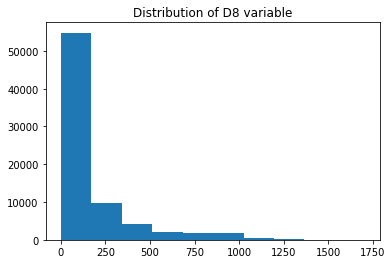

In [ ]:
plt.hist(train['D8']);
plt.title('Distribution of D8 variable');

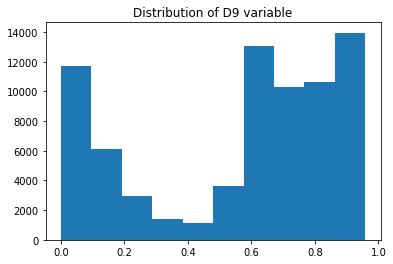

In [ ]:
plt.hist(train['D9']);
plt.title('Distribution of D9 variable');

In [ ]:
# 음수를 0으로 만들기
for df in [train, test]:
    for col in ['D'+str(i) for i in range(1,16)]:
        df[col] = df[col].clip(0)
    
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

In [ ]:
df.D9_not_na.value_counts()

0    432353
1     74338
Name: D9_not_na, dtype: int64

In [ ]:
df.D8_not_same_day.value_counts()

0    450294
1     56397
Name: D8_not_same_day, dtype: int64

In [ ]:
df.D8_D9_decimal_dist.value_counts()

0.000000000000000    33312
0.041503906250000     5649
0.020996093750000     3560
0.010253906250000     2907
0.083496093750000     2359
0.005371093750000     2279
0.000488281250000     2025
0.002441406250000     1932
0.125000000000000     1661
0.001464843750000     1622
0.958496093750000     1260
0.041656494140625     1226
0.875000000000000     1129
0.916503906250000     1070
0.083312988281250      720
0.041625976562500      542
0.791503906250000      528
0.020874023437500      498
0.833496093750000      484
0.041748046875000      480
0.750000000000000      468
0.010375976562500      408
0.020843505859375      399
0.020812988281250      368
0.166503906250000      367
0.208496093750000      365
0.005249023437500      356
0.041687011718750      342
0.010406494140625      336
0.010437011718750      304
0.005218505859375      285
0.002563476562500      279
0.083374023437500      272
0.002593994140625      260
0.005187988281250      259
0.002624511718750      246
0.001312255859375      241
0

In [ ]:
df.D8.value_counts()

-1       432353
 0        17941
 1         2580
 2         1367
 3         1193
 7          968
 4          918
 5          872
 6          789
 8          673
 9          609
 10         534
 11         504
 14         498
 13         496
 12         483
 15         422
 16         374
 20         365
 21         355
 28         346
 18         330
 17         329
 366        313
 29         302
 25         300
 27         298
 35         298
 33         296
 32         292
 22         281
 19         275
 30         274
 23         269
 34         266
 26         264
 45         253
 31         247
 24         236
 42         234
 41         219
 56         217
 48         214
 36         211
 40         205
 43         197
 38         196
 37         193
 47         192
 105        192
 55         192
 44         192
 49         188
 39         186
 57         184
 68         170
 50         170
 53         168
 65         168
 61         167
 84         166
 51         165
 102    

## TransactionAmt

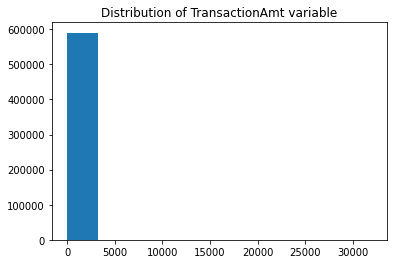

In [ ]:
plt.hist(train['TransactionAmt']);
plt.title('Distribution of TransactionAmt variable');

In [ ]:
np.percentile(train['TransactionAmt'], 99)

1104.0

In [ ]:
# 0부터 5000사이의 값 보기
train['TransactionAmt'] = train['TransactionAmt'].clip(0,5000)
test['TransactionAmt']  = test['TransactionAmt'].clip(0,5000)

# 거래 액수가 일반적인지 아닌지 보기
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

In [ ]:
train.TransactionAmt_check.value_counts()

1    573620
0     16920
Name: TransactionAmt_check, dtype: int64

In [ ]:
test.TransactionAmt_check.value_counts()

1    504328
0      2363
Name: TransactionAmt_check, dtype: int64

In [ ]:
for df in [train, test]:
    df['ProductCD_card1'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str)
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    df['TransactionAmt_dist2'] = df['TransactionAmt'].astype(str) + '_' + df['dist2'].astype(str)
    df['card3_card5'] = df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['ProductCD_TransactionAmt'] = df['ProductCD'].astype(str) + '_' + df['TransactionAmt'].astype(str)
    df['cents'] = np.round(df['TransactionAmt'] - np.floor(df['TransactionAmt']), 3)
    df['ProductCD_cents'] = df['ProductCD'].astype(str) + '_' + df['cents'].astype(str)
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])

In [ ]:
df.ProductCD_card1.value_counts()

W_7919     13037
C_15885    12326
W_9500     11279
W_17188     8401
W_15066     5463
           ...  
R_16710        1
H_13121        1
R_4937         1
W_15001        1
C_16817        1
Name: ProductCD_card1, Length: 20656, dtype: int64

In [ ]:
df.card1_addr1.value_counts()

15885_nan      11533
17188_299.0     5530
12695_325.0     4533
3154_nan        4391
9633_nan        4388
               ...  
14479_324.0        1
14148_337.0        1
8944_nan           1
2356_387.0         1
11835_226.0        1
Name: card1_addr1, Length: 37621, dtype: int64

In [ ]:
df.TransactionAmt_dist2.value_counts()

59.0_nan         27373
117.0_nan        25804
107.9375_nan     20256
57.9375_nan      20066
100.0_nan        14639
                 ...  
75.0_1182.0          1
1011.5_nan           1
1905.0_nan           1
54.40625_25.0        1
350.0_78.0           1
Name: TransactionAmt_dist2, Length: 23013, dtype: int64

In [ ]:
df.ProductCD_TransactionAmt.value_counts()

W_59.0           27365
W_117.0          25802
W_107.9375       20243
W_57.9375        20063
W_49.0           14227
W_226.0          11090
R_100.0          10227
W_39.0            9919
W_29.0            9007
H_50.0            8658
W_47.9375         8230
W_35.9375         7558
W_171.0           7272
W_77.0            6653
W_34.0            6350
W_30.953125       6290
W_25.953125       6288
W_335.0           5451
H_100.0           5328
W_210.0           5250
R_150.0           5127
R_200.0           4933
W_67.9375         4713
W_97.0            4526
H_25.0            4090
W_58.9375         3960
W_160.0           3959
W_92.0            3742
W_108.9375        3591
R_50.0            3085
R_250.0           2969
W_82.9375         2900
W_280.0           2740
W_554.0           2663
W_445.0           2371
W_312.0           2362
W_141.0           2228
W_87.0            2180
W_87.9375         2119
H_75.0            2094
H_150.0           1954
W_108.5           1843
W_44.0            1829
S_50.0     

In [ ]:
df.TransactionAmt.value_counts()

4.094344615936279    27373
4.770684719085693    25805
4.690774440765381    20256
4.076477527618408    20066
4.615120410919189    17568
3.931825637817383    14470
3.912023067474365    14235
5.424950122833252    11090
3.688879489898682     9926
3.401197433471680     9021
3.890543937683105     8233
5.017279624938965     7992
3.609227180480957     7559
5.147494316101074     7273
3.258096456527710     6779
4.356709003448486     6660
3.555348157882690     6388
5.303304672241211     6343
3.294099330902100     6294
3.464269876480103     6290
5.817111015319824     5452
5.351858139038086     5252
4.233200073242188     4722
4.584967613220215     4550
4.330733299255371     4186
5.081404209136963     3980
4.093302249908447     3961
4.532599449157715     3763
5.525453090667725     3647
4.699912071228027     3599
3.433987140655518     2941
4.430072307586670     2904
2.772588729858398     2783
5.638354778289795     2745
6.318968296051025     2663
6.100318908691406     2371
5.746203422546387     2362
3

In [ ]:
test['ProductCD_card1']

0         W_10409
1          W_4272
2          W_4476
3         W_10989
4         W_18018
           ...   
506686    C_13832
506687     C_3154
506688    W_16661
506689    W_16621
506690     C_5713
Name: ProductCD_card1, Length: 506691, dtype: object

In [ ]:
train = train.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)
test = test.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)

In [ ]:
# 집계를 위한 임시 항목
for df in [train, test]:
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = ((df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear).astype(np.int16)

    df['DT_hour'] = df['DT'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['DT'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['DT'].dt.day.astype(np.int8)

    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december'] == 12).astype(np.int8)

## Validation

In [ ]:
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def freq_encode_full(df1, df2, col, normalize=True):
    df = pd.concat([df1[col], df2[col]])
    freq_dict = df.value_counts(dropna=False, normalize=normalize).to_dict()
    col_name = col + '_freq_enc_full'
    return col_name, freq_dict

In [ ]:
def process_data(df_train: pd.DataFrame, df_test: pd.DataFrame):
    train_df = df_train.copy()
    test_df = df_test.copy()
    remove_features = ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week',
                       'DT_day_month',
                       'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid',
                       'D5_DT_W_std_score',
                       'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score',
                       'D11_DT_W_std_score',
                       'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score',
                       'card3_card5_DT_D', 'ProductCD_cents_DT_D',
                       'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist',
                       'D10_DT_W_std_score', 'D8_DT_D_std_score',
                       'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score',
                       'ProductCD_TransactionAmt']

    for col in ['card1', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2']:
        valid_card = pd.concat([train_df[[col]], test_df[[col]]])
        valid_card = valid_card[col].value_counts()

        valid_card = valid_card[valid_card > 2]
        valid_card = list(valid_card.index)

        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)

        test_df[col] = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    i_cols = ['C' + str(i) for i in range(1, 15)]
    for df in [train_df, test_df]:
        for col in i_cols:
            max_value = train_df[train_df['DT_M'] == train_df['DT_M'].max()][col].max()
            df[col] = df[col].clip(None, max_value)

    nans_groups = {}
    nans_df = pd.concat([train_df, test_df]).isna()

    i_cols = ['V' + str(i) for i in range(1, 340)]
    for col in i_cols:
        cur_group = nans_df[col].sum()
        if cur_group > 0:
            try:
                nans_groups[cur_group].append(col)
            except:
                nans_groups[cur_group] = [col]

    for i, (n_group, n_cols) in enumerate(nans_groups.items()):
        for df in [train_df, test_df]:
            df[f'nan_group_{i}_sum'] = df[n_cols].sum(axis=1)
            df[f'nan_group_{i}_mean'] = df[n_cols].mean(axis=1)
            df[f'nan_group_{i}_std'] = df[n_cols].std(axis=1)

    del nans_groups, nans_df
    remove_features += i_cols
    i_cols = [i for i in i_cols if i not in ['V258', 'V306', 'V307', 'V308', 'V294']]
    train_df = train_df.drop(i_cols, axis=1)
    test_df = test_df.drop(i_cols, axis=1)


    i_cols = [
        'ProductCD_TransactionAmt', 'ProductCD_cents', 'cents',
        'DeviceInfo', 'DeviceInfo_device', 'DeviceInfo_version',
        'id_30', 'id_30_device', 'id_30_version',
        'id_31', 'id_31_device',
        'id_33',
    ]
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
              'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
              'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'card1', 'card2', 'card3', 'card5', 'ProductCD_card1',
              'card1_addr1', 'TransactionAmt_dist2']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    return train_df, test_df, remove_features

In [ ]:
%%time
X_train, X_val, remove_features = process_data(X_train, X_val)

CPU times: user 39.7 s, sys: 2.84 s, total: 42.6 s
Wall time: 42.7 s


## Feature engineering

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)

    feature_columns = [col for col in list(train_df) if col not in remove_features]
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    print(f'train.shape : {train_df[feature_columns].shape}, test.shape : {test_df[feature_columns].shape}')

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [ ]:
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

## LightGBM

In [ ]:
lgb_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'bagging_seed': seed,
    'feature_fraction': 0.7,
    'feature_fraction_seed': seed,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1,
    'seed': seed,
}

In [ ]:
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_pred, y_true):
    return 'auc', fast_auc(y_true.get_label(), y_pred), True


In [ ]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=0, seed_range=3, lgb_params=None,
                        category_cols=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    auc_scores = []
    best_iterations = []
    val_preds = np.zeros((X_val.shape[0], 3))

    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0

    for i, s in enumerate(range(seed, seed + seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s

        clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data],
                        categorical_feature=categorical_features,
                        early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)

        best_iteration = clf.best_iteration
        best_iterations.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred

        auc = fast_auc(y_val, val_pred)
        auc_scores.append(auc)
        print('seed:', s, ', auc:', auc, ', best_iteration:', best_iteration)

        feature_importance_df['gain_importance'] += clf.feature_importance('gain') / seed_range

    auc_scores = np.array(auc_scores)
    best_iterations = np.array(best_iterations)
    best_iteration = int(np.mean(best_iterations))

    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(
        f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_scores):.5f}+/-{np.std(auc_scores):.5f}, avg best iteration: {best_iteration}')

    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False).reset_index(
        drop=True)
    plt.figure(figsize=(16, 12));
    sns.barplot(x="gain_importance", y="feature", data=feature_importance_df[:50])
    plt.title('LGB Features (avg over folds)');

    return feature_importance_df, best_iteration, val_preds

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.961083	valid_1's auc: 0.905683
[400]	training's auc: 0.986283	valid_1's auc: 0.922648
[600]	training's auc: 0.994881	valid_1's auc: 0.929472
[800]	training's auc: 0.997946	valid_1's auc: 0.932182
[1000]	training's auc: 0.999135	valid_1's auc: 0.933272
[1200]	training's auc: 0.999618	valid_1's auc: 0.934336
[1400]	training's auc: 0.99983	valid_1's auc: 0.934822
[1600]	training's auc: 0.999921	valid_1's auc: 0.935068
[1800]	training's auc: 0.999959	valid_1's auc: 0.935207
[2000]	training's auc: 0.999993	valid_1's auc: 0.935021
[2200]	training's auc: 0.999998	valid_1's auc: 0.935371
[2400]	training's auc: 0.999999	valid_1's auc: 0.935324
[2600]	training's auc: 1	valid_1's auc: 0.93516
Early stopping, best iteration is:
[2247]	training's auc: 0.999998	valid_1's auc: 0.935404
seed: 0 , auc: 0.9354035818852345 , best_iteration: 2247
Training until validation scores don't improve for 500 rounds.
[200]	train

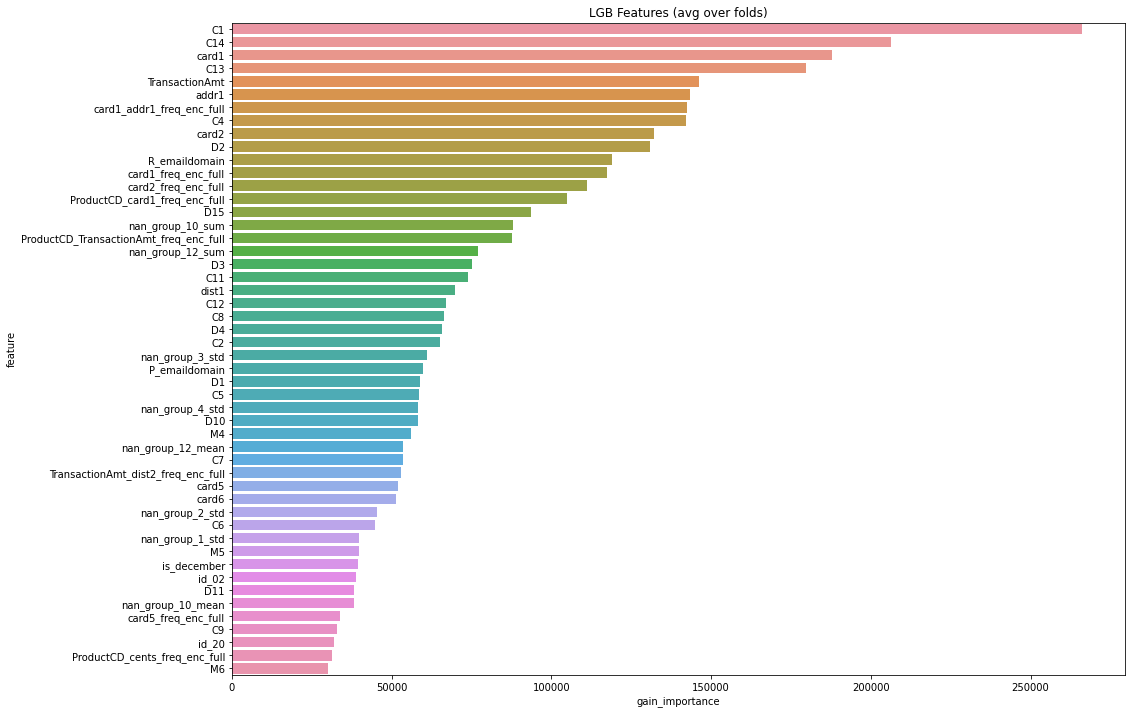

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

## Making prediction

In [ ]:
def prediction(X, y, X_test, best_iteration, seed=seed, category_cols=None, n_folds=5):
    print('best iteration:', best_iteration)
    preds = np.zeros((X_test.shape[0], n_folds))

    print(X.shape, X_test.shape)

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for i, (trn_idx, _) in enumerate(skf.split(X, y)):
        fold = i + 1

        tr_x, tr_y = X.iloc[trn_idx, :], y.iloc[trn_idx]

        tr_data = lgb.Dataset(tr_x, label=tr_y)

        clf = lgb.train(lgb_params, tr_data, best_iteration, categorical_feature=category_cols)
        preds[:, i] = clf.predict(X_test)

    return preds


In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

In [ ]:
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)

best iteration: 1854
(590540, 178) (506691, 178)


In [ ]:
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('fraud_submission1.csv', index=False)

## More feature engineering

In [ ]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period

            dt_df[col] = dt_df[col].astype(float)

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col + '_min_max'] = (dt_df[col] - dt_df['temp_min']) / (dt_df['temp_max'] - dt_df['temp_min'])
            dt_df[new_col + '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_min'], dt_df['temp_max'], dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

# Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')


    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.961784	valid_1's auc: 0.904921
[400]	training's auc: 0.988269	valid_1's auc: 0.921513
[600]	training's auc: 0.996282	valid_1's auc: 0.928038
[800]	training's auc: 0.998814	valid_1's auc: 0.930666
[1000]	training's auc: 0.999598	valid_1's auc: 0.932088
[1200]	training's auc: 0.999853	valid_1's auc: 0.932646
[1400]	training's auc: 0.999943	valid_1's auc: 0.933001
[1600]	training's auc: 0.999974	valid_1's auc: 0.933277
[1800]	training's auc: 0.999982	valid_1's auc: 0.933666
[2000]	training's auc: 1	valid_1's auc: 0.933631
[2200]	training's auc: 1	valid_1's auc: 0.933955
[2400]	training's auc: 1	valid_1's auc: 0.933991
[2600]	training's auc: 1	valid_1's auc: 0.934056
[2800]	training's auc: 1	valid_1's auc: 0.93393
[3000]	training's auc: 1	valid_1's auc: 0.93386
Early stopping, best iteration is:
[2670]	training's auc: 1	valid_1's auc: 0.934161
seed: 0 , auc: 0.9341605456293013 , best_iteration: 2670
Trai

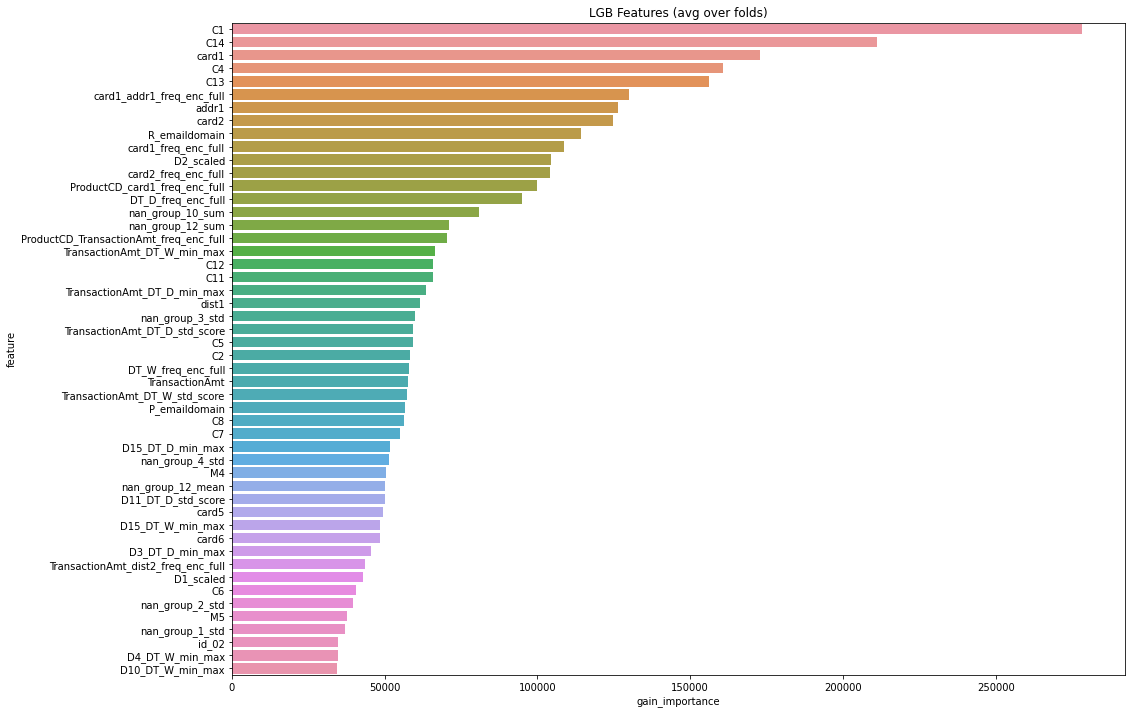

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('fraud_submission2.csv', index=False)

## More feature engineering 2

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]
    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')


    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('fraud_submission3.csv', index=False)

In [ ]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                    columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)
    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

# Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')


    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('fraud_submission4.csv', index=False)

In [ ]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            print('timeblock frequency encoding:', new_col)
            train_df[new_col] = train_df[col].astype(str) + '_' + train_df[period].astype(str)
            test_df[new_col] = test_df[col].astype(str) + '_' + test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts(normalize=True).to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col] = test_df[new_col].map(fq_encode)

            train_df[new_col] = train_df[new_col] / train_df[period + '_freq_enc_full']
            test_df[new_col] = test_df[new_col] / test_df[period + '_freq_enc_full']

    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = ['ProductCD_TransactionAmt', 'ProductCD_cents', 'ProductCD_cents', 'uid', 'card3_card5']
    periods = ['DT_D', 'DT_W']
    train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols)

# Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')


    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('fraud_submission5.csv', index=False)